In [1]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import PIL
from PIL import Image
import random
import numpy as np

In [2]:
import random

class AlzheimersData(data.Dataset):
    
    def __init__(self,imageFolderDataset,should_invert=False,transform=None):
        self.imageFolderDataset=imageFolderDataset
        self.should_invert=should_invert
        self.transform=transform
    
    def __getitem__(self,idx):
        img0_tuple=random.choice(self.imageFolderDataset.imgs) # tuple of the form (Image_PATH,label)
        same_class=random.choice([True,False]) # Whether image 2 should be in same class or not
        
        if(same_class):
            while True:
                img1_tuple=random.choice(self.imageFolderDataset.imgs)
                if(img0_tuple[1]==img1_tuple[1]):
                    break
        else:
            img1_tuple=random.choice(self.imageFolderDataset.imgs)

        img0=Image.open(img0_tuple[0])
        img1=Image.open(img1_tuple[0])
        
        if(self.should_invert):
            img0=PIL.ImageOps.invert(img0)
            img1=PIL.ImageOps.invert(img1)
            
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img0_tuple[1]!=img1_tuple[1])]))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [3]:
train_data=ImageFolder("C:/Datasets/Alzheimer_s Dataset/train")
test_data=ImageFolder("C:/Datasets/Alzheimer_s Dataset/test")

In [4]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

In [5]:
train_data=AlzheimersData(train_data,transform=transform)
test_data=AlzheimersData(test_data,transform=transform)

In [6]:
train_dataloader=data.DataLoader(train_data,batch_size=10,shuffle=True)
testLoader=data.DataLoader(test_data,batch_size=10,shuffle=True)

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(1,1,4),
            nn.MaxPool2d(2, 2)
        )
        self.fc1=nn.Linear(2009,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,4)
        self.softmax=nn.Softmax(dim=1)
        
    def forward(self,input1,input2):
        output1=self.forward_once(input1)
        output2=self.forward_once(input2)
        return output1,output2
        
    def forward_once(self,x):
        x=self.conv1(x)
        x=self.conv1(x)
        x=torch.flatten(x,1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        # x=self.softmax(self.fc3(x))
        return x

In [8]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive Loss Function
    """
    def __init__(self,margin=2.0):
        super().__init__()
        self.margin=margin
    
    def forward(self,output1,output2,label):
        euclidean_distance=F.pairwise_distance(output1,output2)
        loss_contrastive=torch.mean((1-label)*torch.pow(euclidean_distance,2)+
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [9]:
net=SiameseNetwork().cuda()
criterion=ContrastiveLoss().cuda()
optimizer=torch.optim.Adam(net.parameters(),lr=0.0005)

In [10]:
net

SiameseNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 1, kernel_size=(4, 4), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2009, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [11]:
print(next(iter(train_dataloader)))

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1.,

In [12]:
loss_history = [] 
test_loss=[]

In [13]:
for epoch in range(0,10):
    e_loss=0
    count=0
    v_loss=0
    for i, data in enumerate(train_dataloader):
        # print(data)
        count+=1
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1,output2 = net.forward(img0,img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,label)
        e_loss+=loss_contrastive.item()
        loss_contrastive.backward()
        optimizer.step()
    
    with torch.no_grad():
        for i, data in enumerate(testLoader):
            img0, img1 , label = data
            img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
            output1,output2 = net.forward(img0,img1)
            v_loss=criterion(output1,output2, label)
    
    test_loss.append(v_loss)
    loss_history.append(e_loss/count)
    print(f"Epoch {epoch} Loss:{e_loss/count} Val_Loss:{v_loss}")

Epoch 0 Loss:0.9550496185557884 Val_Loss:1.4908387660980225
Epoch 1 Loss:0.91364744081948 Val_Loss:0.41095662117004395
Epoch 2 Loss:0.9038883027807604 Val_Loss:0.4115821421146393
Epoch 3 Loss:0.9237050248226459 Val_Loss:0.7496629953384399
Epoch 4 Loss:0.9306301416477032 Val_Loss:1.0668288469314575
Epoch 5 Loss:0.9108325751538281 Val_Loss:0.017492949962615967
Epoch 6 Loss:0.9211429735794519 Val_Loss:1.1480331420898438
Epoch 7 Loss:0.9242084233732949 Val_Loss:1.0960839986801147
Epoch 8 Loss:0.9070788905765229 Val_Loss:1.58480703830719
Epoch 9 Loss:0.935821466423847 Val_Loss:1.1028062105178833


In [14]:
import matplotlib.pyplot as plt

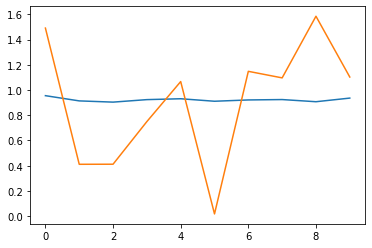

In [15]:
plt.plot(loss_history)
plt.plot(test_loss)

In [16]:
import torchvision

In [17]:
dataiter=iter(testLoader)
x0,x1,label= next(dataiter)

Text(0.5, 1.0, 'Dissimilarity: 0.14499999582767487')

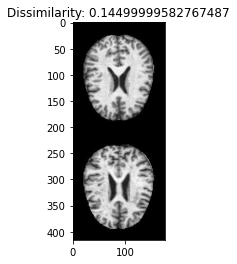

In [18]:
_,x1,label=next(dataiter)
x0.squeeze().shape
output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
euclidean_distance = F.pairwise_distance(output1, output2)
concat=torch.cat((x0.squeeze(),x1.squeeze()),1)
plt.imshow(concat[0],cmap="gray")
plt.title(f'Dissimilarity: {round(euclidean_distance.cpu().data.numpy()[0],3)}')